# GAN이란?
GAN의 핵심은 데이터를 그냥 생성하는 것이 아닌 Generator(G)와 Disciriminator(D)를 서로 대립시켜 training 데이터의 분포를 학습하는 것이다.
기본 GAN의 discriminator loss는 E[log(D(x))] + E[log(1-D(G(z)))]인데, 이 문제는 Jensen-Shannon divergence를 최소화 하는 문제와 같다. 따라서 원래의 데이터의 분포와 G가 생성하는 분포 사이의 차이를 줄이면서 학습한다.

LSGAN은 기존GAN의 목적함수와는 달리 목적함수 E[log(D(x)-1)^2]*0.5 + E[log(D(G(z))^2)]*0.5을 사용한다. 기존GAN에 비해 좀 더 안정적으로 실제 데이터와 거리가 가까운 데이터를 Generate할 수 있는 효과가 있다.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow.contrib.slim as slim
from scipy.misc import imread, imresize
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline
print('tensorflow version is : ',tf.__version__)

tensorflow version is :  1.2.1


# Download MNIST Dataset

In [2]:
mnist = input_data.read_data_sets('./data/mnist', one_hot=True) # download

Extracting ./data/mnist\train-images-idx3-ubyte.gz
Extracting ./data/mnist\train-labels-idx1-ubyte.gz
Extracting ./data/mnist\t10k-images-idx3-ubyte.gz
Extracting ./data/mnist\t10k-labels-idx1-ubyte.gz


# Define functions
GAN network를 구성할 function들을 선언한다.

get_session : tensorflow의 세션을 정의한다.<br />
make_noise : G에 사용될 noise를 생성<br />
lrelu : 활성함수 leaky relu를 구현<br />
generator : generator 구현<br />
discriminator : discriminator 구현<br />
generator_conv : convolution layer를 사용한 generator 구현<br />
discriminator_conv : convolution layer를 사용한 discriminator 구현<br />
loss_gan : GAN에 사용되는 목적함수 E[log(D(x))] + E[log(1-D(G(z)))], E[log(D(G(z)))]<br />
loss_lsgan : LSGAN에 사용되는 목적함수 E[log(D(x)-1)^2]*0.5 + E[log(D(G(z))^2)]*0.5, E[log(D(z)-1)^2]*0.5<br />
display : Generator에서 생성된 데이터와 함께 생성된 데이터가 Discriminator에 의해 진짜(True) 혹은 가짜(False)인지 판별한 결과를 보여줌<br />
show_loss : training하는 동안의 Generator와 Discriminator의 loss변화를 보여줌

In [3]:
def get_session():
    config = tf.ConfigProto()
    config.allow_soft_placement=True
    config.gpu_options.allow_growth = False
    config.log_device_placement=False
    sess = tf.Session(config = config)
    
    return sess
    
def make_noise(batch_size, noise_size):
    return np.random.randn(batch_size, noise_size)    
    
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

    

def generator(Z, layer1,  name = 'Generator'):
    with tf.variable_scope(name):
        fn = tf.nn.relu
        L1 = tf.layers.dense(Z, layer1, activation = fn)

        L2 = tf.layers.dense(L1, 784, activation = tf.nn.sigmoid)
        
        return L2
    
def discriminator(Z, layer1, name = 'Discriminator', reuse = None):
    with tf.variable_scope(name) as disc:
        if reuse:
            disc.reuse_variables()
            
        fn = tf.nn.relu
        L1 = tf.layers.dense(Z, layer1, activation = fn)

        L2 = tf.layers.dense(L1, 1, activation = None)
        
        return L2
    
def generator_conv(Z, feat_map1, feat_map2, filter_size, is_training = True, name = 'Generator_conv'):
    with tf.variable_scope(name):
       
        L1 = slim.fully_connected(Z, 1024, activation_fn = tf.nn.relu,weights_initializer = slim.xavier_initializer(), normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training})
        
        L2 = slim.fully_connected(L1, 7*7*128, activation_fn = tf.nn.relu,weights_initializer = slim.xavier_initializer(), normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training})
        L2 = tf.reshape(L2, [-1,7,7,128])
        L3 = slim.conv2d_transpose(L2, feat_map1,filter_size,stride = 2, padding = 'SAME', activation_fn = tf.nn.relu,weights_initializer = slim.xavier_initializer(), normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training}, scope = 'slim_conv_transpose1')
        L4 = slim.conv2d_transpose(L3, feat_map2,filter_size,stride = 2, padding = 'SAME', activation_fn = tf.nn.sigmoid,weights_initializer =slim.xavier_initializer() ,scope = 'slim_conv_transpose2')
        L4 = tf.reshape(L4, [-1,784])
        return L4
    
def discriminator_conv(Z, feat_map1,feat_map2, filter_size, is_training=True, name = 'Discriminator_conv', reuse = None):
    with tf.variable_scope(name) as disc:
        if reuse:
            disc.reuse_variables()
        
        init = slim.xavier_initializer()
        fn = lrelu
        Z = tf.reshape(Z, [-1, 28, 28, 1]) # transter to 4dim in slim
        
        L1 = slim.conv2d(Z, feat_map1,filter_size, padding = 'SAME', activation_fn = fn, weights_initializer = init, normalizer_fn = slim.batch_norm,normalizer_params = {'is_training' : is_training}, scope = 'slim_conv1')
        
        L2 = slim.conv2d(L1, feat_map2,filter_size, padding = 'SAME', activation_fn = fn, weights_initializer = init, normalizer_fn = slim.batch_norm, normalizer_params = {'is_training' : is_training},scope = 'slim_conv2')
        
        L2 = slim.flatten(L2, scope = 'flatten_slim_layer')
        
        L3 = slim.fully_connected(L2, 1, activation_fn = None)
        

        
        return L3
    
def loss_gan(D_real, D_fake):
    loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_real,labels = tf.ones_like(D_real)))
    loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake,labels = tf.zeros_like(D_fake)))
    loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake,labels = tf.ones_like(D_fake)))
    return loss_real + loss_fake, loss_G


def loss_lsgan(D_real, D_fake):
    loss_D = tf.reduce_mean(tf.square(D_real - 1) + tf.square(D_fake))*0.5
             
    loss_G = tf.reduce_mean(tf.square(D_fake - 1))*0.5
    return loss_D, loss_G


def display(sess, G, D_real, noise,fig_num=5):
    
 
    images = sess.run(G, feed_dict = {Z:noise, is_training : False})
    result = sess.run(D_real, feed_dict = {X:images, is_training : False})
    result = result>0.5
    
    fig = plt.figure(figsize=(15,8))
    for i in range(fig_num):
        snap = fig.add_subplot(1, fig_num, i+1)
        snap.set_xticks([])
        snap.set_yticks([])
        
        snap.set_title('{}'.format(result[i]))
        plt.imshow(images[i].reshape([28, 28]), cmap = 'gray')
    plt.show()
    
def show_loss(total_loss):
    
    total_loss = np.array([total_loss])
    plt.plot(total_loss.T[0], label = 'Discriminator')
    plt.plot(total_loss.T[1], label = 'Generator')
    plt.title("Training Loss")
    plt.legend()
    plt.show()

# Hyperparameter Settings

In [4]:
batch_size = 100
noise_size = 256

epoch = 202

learning_rate = 0.0002

# VanillaGAN setting
    * Loss of D = E[log(D(x))] + E[log(1-D(G(z)))]
    * Loss of G = E[log(D(G(z)))]

In [5]:
X = tf.placeholder(tf.float32, [None, 784])
Z = tf.placeholder(tf.float32, [None, noise_size])
is_training = tf.placeholder(tf.bool)

G = generator(Z, 784)
D_real = discriminator(X, 784)
D_fake = discriminator(G, 784, reuse = True)

loss_D, loss_G = loss_gan(D_real, D_fake)

g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Generator')
d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Discriminator')

# 보통 G의 학습이 D에 비해 잘 안된다고 한다. 따라서 learning rate를 적절히 조절하여 여기서는 D의 학습률을 1/2로 train시킨다.
d_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate/2)
g_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

d_grad = d_optimizer.compute_gradients(loss_D, d_vars)
g_grad = g_optimizer.compute_gradients(loss_G, g_vars)

update_d = d_optimizer.apply_gradients(d_grad)
update_g = g_optimizer.apply_gradients(g_grad)

# Train VanillaGAN

Epoch : 0, D_loss = 0.1302, G_loss = 3.1688


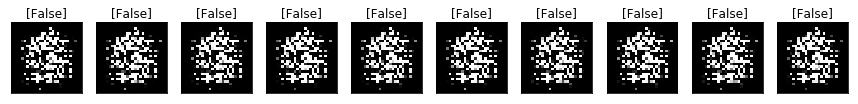

Epoch : 20, D_loss = 0.1296, G_loss = 4.4120


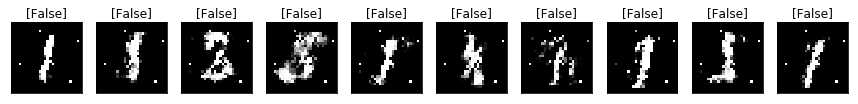

Epoch : 40, D_loss = 0.2272, G_loss = 5.6167


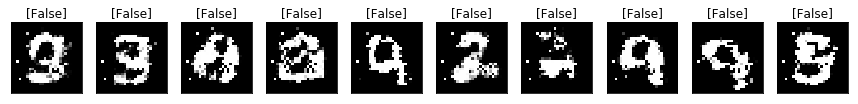

Epoch : 60, D_loss = 0.0794, G_loss = 4.9547


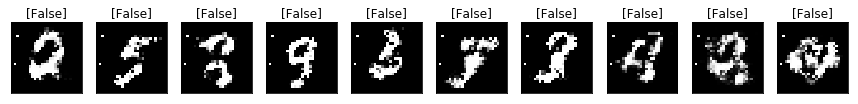

Epoch : 80, D_loss = 0.6499, G_loss = 2.1464


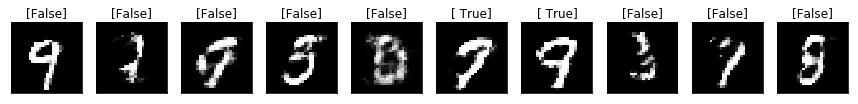

Epoch : 100, D_loss = 0.4487, G_loss = 2.4274


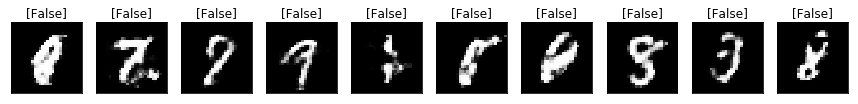

Epoch : 120, D_loss = 0.5005, G_loss = 2.3376


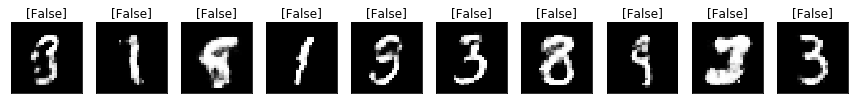

Epoch : 140, D_loss = 0.5210, G_loss = 2.2914


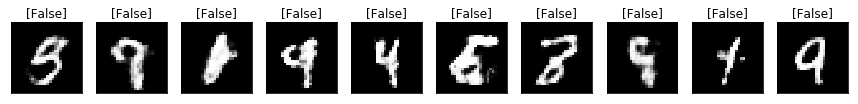

Epoch : 160, D_loss = 0.5350, G_loss = 2.1319


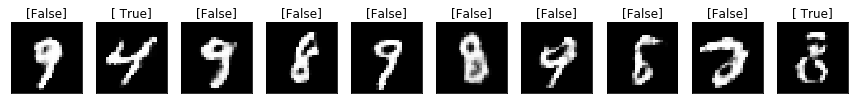

Epoch : 180, D_loss = 0.5037, G_loss = 2.2633


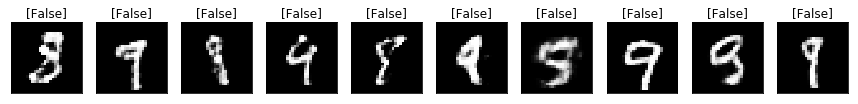

Epoch : 200, D_loss = 0.4529, G_loss = 2.1964


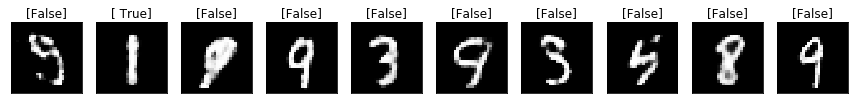

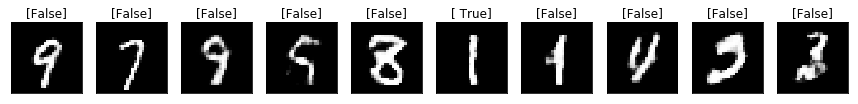

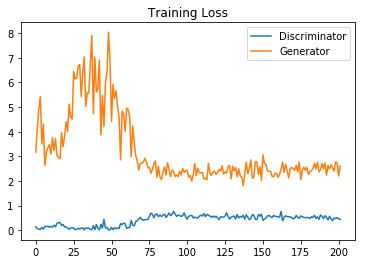

In [6]:
with get_session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    total_loss = []
    for step in range(epoch):
        loss_val_D, loss_val_G = 0,0
        total_batch = int(mnist.train.num_examples/batch_size)
        
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            noise_z = make_noise(batch_size, noise_size)
            
            
            _, loss_val_D = sess.run([update_d, loss_D], feed_dict = {X:batch_xs
                                                                       , Z:noise_z})
            _, loss_val_G = sess.run([update_g, loss_G], feed_dict = {Z:noise_z})
        
            
        total_loss.append([loss_val_D, loss_val_G])    
        if step%20==0:
            print('Epoch : {}, D_loss = {:.4f}, G_loss = {:.4f}'.format(step, loss_val_D, loss_val_G))
            
            g_size = 10
            z = make_noise(g_size, noise_size)
            display(sess, G, D_real, z, fig_num = g_size)
            
    g_size = 10
    z = make_noise(g_size, noise_size)
    display(sess, G, D_real, z, fig_num = g_size)
    
    show_loss(total_loss)
    

# Least Squares GAN(LSGAN) setting
    * Loss of D = E[log(D(x)-1)^2]*0.5 + E[log(D(G(z))^2)]*0.5
    * Loss of G = E[log(D(z)-1)^2]*0.5

In [7]:
loss_D, loss_G = loss_lsgan(D_real, D_fake)

g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Generator')
d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Discriminator')


d_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate/4)
g_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

d_grad = d_optimizer.compute_gradients(loss_D, d_vars)
g_grad = g_optimizer.compute_gradients(loss_G, g_vars)

update_d = d_optimizer.apply_gradients(d_grad)
update_g = g_optimizer.apply_gradients(g_grad)

# Train LSGAN

Epoch : 0, D_loss = 0.0053, G_loss = 0.5300


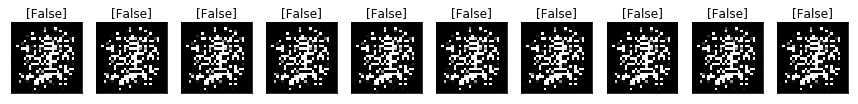

Epoch : 20, D_loss = 0.0009, G_loss = 0.5189


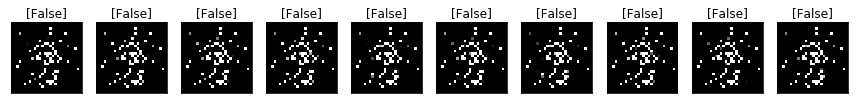

Epoch : 40, D_loss = 0.0028, G_loss = 0.5038


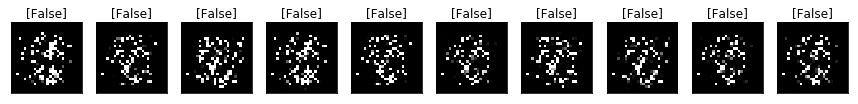

Epoch : 60, D_loss = 0.0116, G_loss = 0.4926


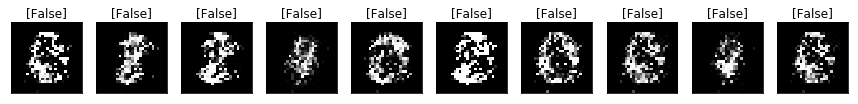

Epoch : 80, D_loss = 0.0760, G_loss = 0.3831


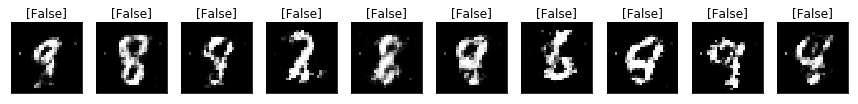

Epoch : 100, D_loss = 0.1131, G_loss = 0.3068


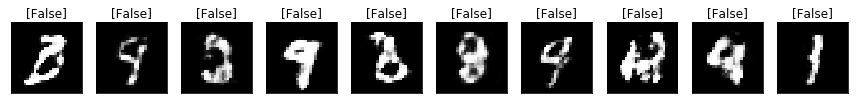

Epoch : 120, D_loss = 0.0910, G_loss = 0.3167


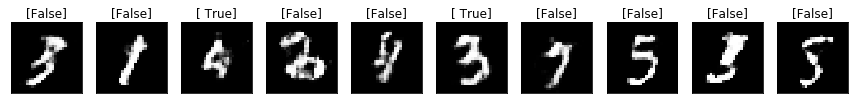

Epoch : 140, D_loss = 0.0934, G_loss = 0.3541


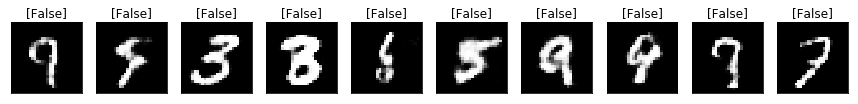

Epoch : 160, D_loss = 0.0988, G_loss = 0.3845


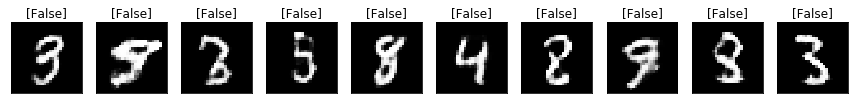

Epoch : 180, D_loss = 0.0838, G_loss = 0.3495


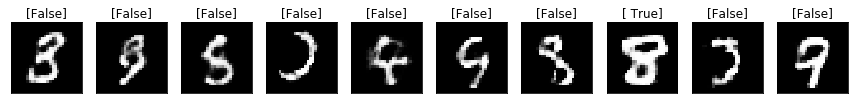

Epoch : 200, D_loss = 0.0876, G_loss = 0.3595


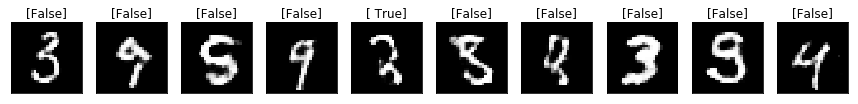

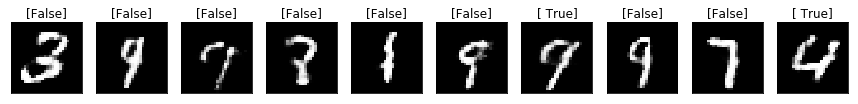

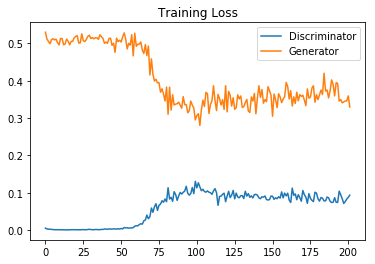

In [8]:
with get_session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    total_loss = []
    for step in range(epoch):
        loss_val_D, loss_val_G = 0,0
        total_batch = int(mnist.train.num_examples/batch_size)
        
        
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            noise_z = make_noise(batch_size, noise_size)
            
          
            _, loss_val_D = sess.run([update_d, loss_D], feed_dict = {X:batch_xs
                                                                       , Z:noise_z})
            _, loss_val_G = sess.run([update_g, loss_G], feed_dict = {Z:noise_z})
        
        total_loss.append([loss_val_D, loss_val_G])
            
        if step%20==0:
            print('Epoch : {}, D_loss = {:.4f}, G_loss = {:.4f}'.format(step, loss_val_D, loss_val_G))
            g_size = 10
            z = make_noise(g_size, noise_size)
            display(sess, G, D_real, z, fig_num = g_size)
            
    g_size = 10
    z = make_noise(g_size, noise_size)
    display(sess, G, D_real, z, fig_num = g_size)            
    show_loss(total_loss)

# LSGAN with Convolution layers settings

In [9]:
G = generator_conv(Z, 64, 1, [3,3])
D_real = discriminator_conv(X, 32, 64, [5,5])
D_fake = discriminator_conv(G, 32, 64, [5,5], reuse = True)

loss_D, loss_G = loss_lsgan(D_real, D_fake)

g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Generator')
d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Discriminator')


d_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
g_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

d_grad = d_optimizer.compute_gradients(loss_D, d_vars)
g_grad = g_optimizer.compute_gradients(loss_G, g_vars)

update_d = d_optimizer.apply_gradients(d_grad)
update_g = g_optimizer.apply_gradients(g_grad)

# Train LSGAN with Convolution layers

Epoch : 0, D_loss = 0.0949, G_loss = 0.4514


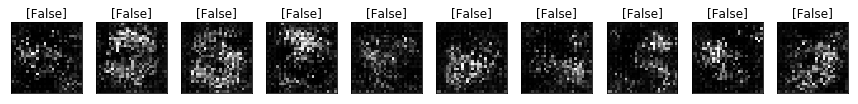

Epoch : 10, D_loss = 0.1338, G_loss = 0.2639


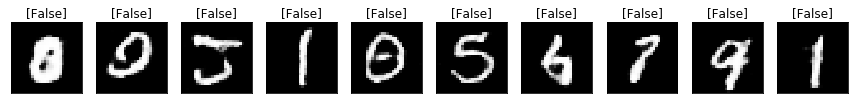

Epoch : 20, D_loss = 0.0971, G_loss = 0.4216


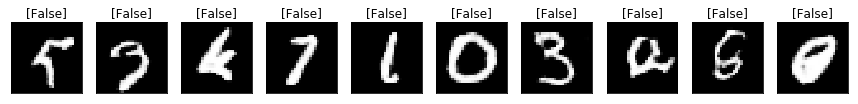

Epoch : 30, D_loss = 0.1831, G_loss = 0.3724


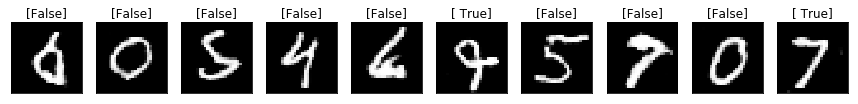

Epoch : 40, D_loss = 0.1381, G_loss = 0.2442


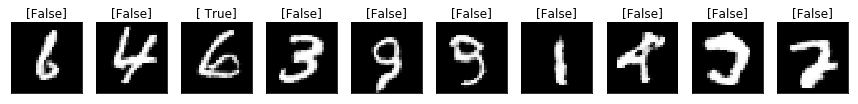

Epoch : 50, D_loss = 0.1349, G_loss = 0.2901


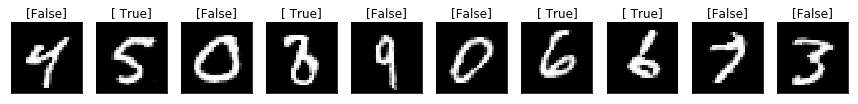

Epoch : 60, D_loss = 0.2949, G_loss = 0.2769


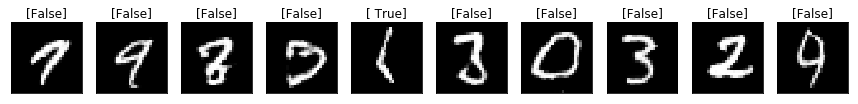

Epoch : 70, D_loss = 0.1496, G_loss = 0.2656


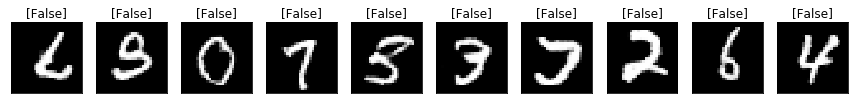

Epoch : 80, D_loss = 0.2973, G_loss = 0.6117


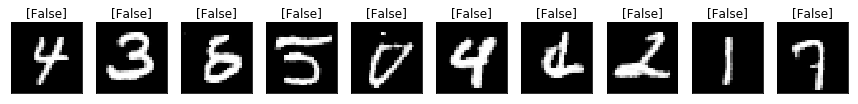

Epoch : 90, D_loss = 0.2203, G_loss = 0.2008


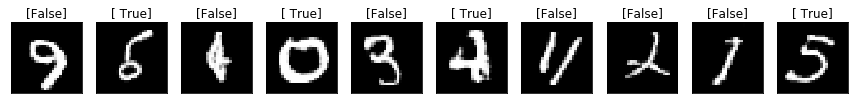

Epoch : 100, D_loss = 0.2269, G_loss = 0.1320


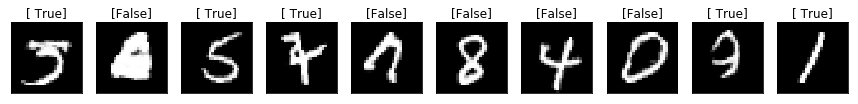

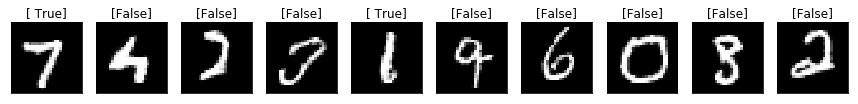

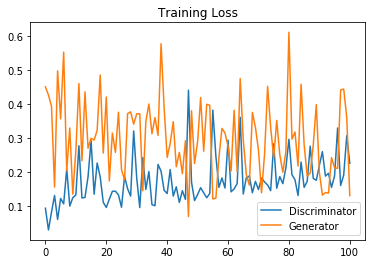

In [10]:
with get_session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    total_loss = []
    for step in range(int(epoch/2)):
        loss_val_D, loss_val_G = 0,0
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            noise_z = make_noise(batch_size, noise_size)
            

            _, loss_val_D = sess.run([update_d, loss_D], feed_dict = {X:batch_xs
                                                                       , Z:noise_z, is_training:True})
            _, loss_val_G = sess.run([update_g, loss_G], feed_dict = {Z:noise_z, is_training:True})
        total_loss.append([loss_val_D, loss_val_G])
        
        if step%10==0:
            print('Epoch : {}, D_loss = {:.4f}, G_loss = {:.4f}'.format(step, loss_val_D, loss_val_G))
            g_size = 10
            z = make_noise(g_size, noise_size)
            display(sess, G, D_real, z, fig_num = g_size)
    g_size = 10
    z = make_noise(g_size, noise_size)
    display(sess, G, D_real, z, fig_num = g_size)        
    show_loss(total_loss)